# **Lab 4: The Multi-Layer Perceptron**
### Authors: Will Lahners, Edward Powers, and Nino Castellano
________________________________________________________________

## **Describing the Data**

This dataset from Kaggle, contains US Census data taken from the DP03 and DP05 tables of the 2015 American Community Survey 5-year estimates. We will be utilizing the *acs2015_census_tract_data.csv* file which is data for each census tract in the US, including DC and Puerto Rico. A tract ID, also known as a GEOID (Geographic Identifier), is a numeric code assigned to specific geographic areas by the Census Bureau and other state and federal agencies. These codes uniquely identify various administrative, legal, and statistical geographic entities for which the Census Bureau collects and tabulates data. Our classification task we will be:

- Predicting, for each tract ID, what the child poverty rate will be. 

We are converting this from regression to four levels of classification by quantizing the variable of interest. 

We've decided to go ahead with the option of removing the "County" and "TractId" variables due to the fact that they both provide unnecessary information needed for our classification task. Including the county would be unnecessary data given that their could be multiple TractId's in the same county. However, the same could be said about the "State" variable as well but there aren't as many states as there is counties so that leads to more computational power when we eventually one-hot encode these features which is another reason why we decided to remove it. There are only 52 states in total compared to the hundreds of counties. Removing the "TractId" variable stems from the fact that in our dataframe each observation is assigned a unique Id value meaning that the TractId will no longer provide any helpful insight besides being extra and redundant.

> **(Step 1)** Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric. **(Step 2)** Remove any observations that having missing data. **(Step 3)** Encode any string data as integers for now. **(Step 4)** You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable.

## **Load, Split, and Balance**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# (1) Load the data into a pandas DataFrame
data = pd.read_csv('./acs2017_census_tract_data.csv')
data = pd.DataFrame(data)

# (2) Remove observations that have missing data
data = data.dropna()

# (3) Encode any string data as integers for now (Credits to ChatGPT)
le = LabelEncoder()
data['State'] = le.fit_transform(data['State'])
data['County'] = le.fit_transform(data['County'])

# (4) Removing "County" and 'TractId' variable
data = data.drop(['TractId', 'County'], axis = 1) 

pd.set_option('display.max_columns', None)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 72718 entries, 0 to 74000
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             72718 non-null  int64  
 1   TotalPop          72718 non-null  int64  
 2   Men               72718 non-null  int64  
 3   Women             72718 non-null  int64  
 4   Hispanic          72718 non-null  float64
 5   White             72718 non-null  float64
 6   Black             72718 non-null  float64
 7   Native            72718 non-null  float64
 8   Asian             72718 non-null  float64
 9   Pacific           72718 non-null  float64
 10  VotingAgeCitizen  72718 non-null  int64  
 11  Income            72718 non-null  float64
 12  IncomeErr         72718 non-null  float64
 13  IncomePerCap      72718 non-null  float64
 14  IncomePerCapErr   72718 non-null  float64
 15  Poverty           72718 non-null  float64
 16  ChildPoverty      72718 non-null  float64
 17

,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,0,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,1407,67826.0,14560.0,33018.0,6294.0,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.0,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,0,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,1652,41287.0,3819.0,18996.0,2453.0,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,0,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,2480,46806.0,9496.0,21236.0,2562.0,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,0.0,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,0,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,3257,55895.0,4369.0,28068.0,3190.0,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,0.0,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,0,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,7229,68143.0,14424.0,36905.0,10706.0,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.0,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


> *The next two requirements will need to be completed together as they might depend on one another:*

> **[.5 points]** Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.

We decided to go along the balancing method suggested in the instructions, quantizing the "ChildPoverty" variable into four different classes. This is because using quantization thresholds for balancing the dataset simplifies the classification task by categorizing the poverty rate into discrete levels, such as low, medium, high, and very high. This approach ensures a balanced representation of each category and facilitates clear interpretation of the results, aiding policymakers in understanding poverty severity across different areas. By mitigating imbalanced data challenges and providing meaningful bins, quantization supports the objective of predicting poverty levels for each Tract ID and informs targeted interventions and policies to address disparities effectively.

Also regarding the question of balancing both the training and testing sets, we believe that just balancing the training set would be more effective. While it's essential to balance the training set to ensure the model learns from a diverse set of instances, it's equally important to evaluate the model on an unbiased testing set that reflects the true distribution of classes in real-world data. Therefore, balancing should typically be applied to the training set only.

In [2]:
# Using Quantization thresholds for Balancing
data['ChildPovertyClass'] = pd.qcut(data['ChildPoverty'], q=4, labels=['Low', 'Medium', 'High', 'Extreme'])

# Dropping the orginal Child Poverty Variable since we now have the 4 classes
data.drop(['ChildPoverty'], axis = 1, inplace = True)

# Tranform the Labels into discret values 0, 1, 2, 3
data['ChildPovertyClass'] = le.fit_transform(data['ChildPovertyClass'])

data.head(10)

,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,ChildPovertyClass
0,0,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,1407,67826.0,14560.0,33018.0,6294.0,10.7,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.0,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6,1
1,0,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,1652,41287.0,3819.0,18996.0,2453.0,22.4,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4,0
2,0,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,2480,46806.0,9496.0,21236.0,2562.0,14.7,27.9,19.4,33.3,9.9,9.6,88.3,8.4,0.0,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7,1
3,0,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,3257,55895.0,4369.0,28068.0,3190.0,2.3,29.0,16.6,25.8,9.1,19.5,82.3,11.2,0.0,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1,2
4,0,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,7229,68143.0,14424.0,36905.0,10706.0,12.2,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.0,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3,1
5,0,3620,1765,1855,3.0,70.7,25.1,0.0,0.0,0.0,2687,44549.0,16126.0,27038.0,4427.0,13.6,25.2,24.6,29.0,8.1,13.1,83.0,4.8,0.0,0.7,3.5,8.0,21.1,1364,84.0,14.1,1.9,0.0,6.1,1
6,0,3420,1459,1961,4.0,78.0,13.7,0.6,0.0,0.0,2538,41250.0,16811.0,19028.0,2587.0,27.0,25.4,35.0,21.6,5.6,12.4,89.0,11.0,0.0,0.0,0.0,0.0,16.4,1418,77.4,17.6,5.0,0.0,16.9,1
7,0,2913,1495,1418,4.2,86.3,7.1,1.5,0.0,0.0,2163,80089.0,13397.0,36631.0,5174.0,12.0,46.0,9.1,30.6,8.3,6.0,89.5,4.6,0.0,0.0,0.7,5.2,24.6,1369,72.7,17.5,8.8,1.0,7.2,1
8,0,11333,5488,5845,1.4,81.8,15.3,0.0,1.0,0.0,8248,64439.0,8677.0,26621.0,2187.0,14.7,36.8,20.2,19.6,9.3,14.0,89.1,8.7,0.0,0.0,0.0,2.2,27.4,4857,70.1,22.5,7.4,0.0,2.2,1
9,0,6167,3111,3056,1.0,86.2,9.7,0.8,0.3,0.0,4710,49469.0,15517.0,26726.0,3839.0,9.4,32.3,12.7,20.1,6.4,28.6,77.2,11.9,0.0,0.0,5.0,5.9,35.6,2781,80.4,14.5,5.0,0.0,6.8,3


> **[.5 points]** Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is no need to split the data multiple times for this lab.

In [3]:
from sklearn.model_selection import train_test_split

# Handling Target Variable
X = np.array(data.drop(['ChildPovertyClass'], axis=1))
y = data['ChildPovertyClass']

# Test and Train using 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, train_size = 0.8, stratify = y)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

from collections import Counter

n_samples, n_features = X.shape

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))

counts = Counter(y_train)
print('Y-Train:')
for value, count in counts.items():
    print(f"\t{value} occurs {count} times")
    
counts = Counter(y_test)
print('Y-Test:')
for value, count in counts.items():
    print(f"\t{value} occurs {count} times")

n_samples: 72718
n_features: 34
Y-Train:
	2 occurs 14583 times
	3 occurs 14537 times
	1 occurs 14518 times
	0 occurs 14536 times
Y-Test:
	3 occurs 3634 times
	1 occurs 3630 times
	0 occurs 3634 times
	2 occurs 3646 times


Here we split the data into training and testing sets, using the 80/20 split. Given that we are equally interested in the classification performance for each class, we stratified the sets to ensure each class is equally represented within both the training and testing data, reducing the biased toward one class over the others.

> *Note: You will need to one hot encode the target, but do not one hot encode the categorical data until instructed to do so in the lab.* 

## **Pre-processing and Initial Modeling**

> *You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: **(1)** vectorized gradient computation, **(2)** mini-batching, **(3)** cross entropy loss, and **(4)** proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.*

In [4]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
#    init
#    encode_labels
#    initialize weights
#    sigmoid
#    add bias (vector of ones)
#    objective function (cost and regularizer)
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    def _L2_reg(self, lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

This section of code defines a base class called TwoLayerPerceptronBase for a two-layer perceptron neural network. It serves as a foundation for building more specialized classifiers. It includes methods for initializing weights, encoding labels into one-hot representation, implementing the sigmoid activation function, adding bias units, and computing the objective function value and regularization term. Additionally, it provides methods for the feedforward step, computing gradients using backpropagation, and making predictions based on the trained model.

In [5]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

This section of code defines a class TLPMiniBatch, which inherits from the TwoLayerPerceptronBase class. It introduces additional parameters such as alpha, decrease_const, decrease_iter, shuffle, and minibatches to control the learning process. The fit method is implemented to train the neural network using mini-batch gradient descent. It includes functionalities to adapt the learning rate over epochs, shuffle the data if required, split data into mini-batches, perform forward and backward passes for each mini-batch, update weights using momentum, and track performance metrics such as training accuracy and optionally validation accuracy.

In [6]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

This section of code defines a subclass TLPMiniBatchCrossEntropy, which extends TLPMiniBatch. It overrides the _cost method to compute the cross-entropy loss between predicted and actual values. Additionally, it modifies the _get_gradient method to compute gradients for the final layer based on the cross-entropy loss. Specifically, it adjusts the computation of V2 to reflect the derivative of the cross-entropy loss with respect to the output of the final layer. This enables the network to optimize parameters using the cross-entropy loss instead of mean squared error, facilitating better performance, especially in classification tasks.

In [7]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2


This TLPBetterInitial class is a subclass of TLPMiniBatchCrossEntropy. It enhances weight initialization using Glorot and He normalization techniques. In the _initialize_weights method, the weights are initialized based on these techniques. Specifically, Glorot initialization initializes the weights from a uniform distribution within a range determined by the size of the input and output layers. He initialization adjusts the range based on the size of the previous layer, providing better initialization for deeper networks. Additionally, the method sets the bias terms to zero for both layers. This initialization strategy helps mitigate issues such as vanishing and exploding gradients, contributing to more stable and efficient training of neural networks.

In [8]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    print(set(yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    print(set(yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

> **[.5 points]** Use the example two-layer perceptron network from the class example and quantify performance using accuracy. **Do not** normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs.

Epoch: 1/100

Epoch: 100/100

CPU times: user 3min 46s, sys: 2min 59s, total: 6min 45s
Wall time: 52.7 s
Long Run :
Resubstitution acc: 0.2477911094303297
{0, 1, 2, 3}
Validation acc: 0.24793729372937293
{0, 1, 2, 3}


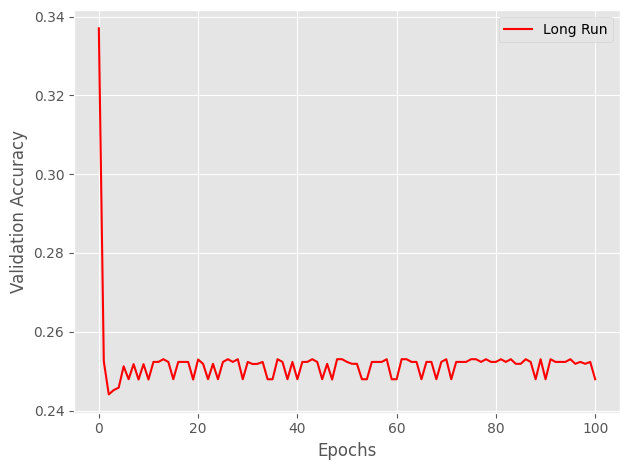

In [9]:
# just for fun, let's look at the output of what happens when we let our system loose
# these values have been hand tuned
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':100, 'eta':0.0001, 
         'alpha':0.0001, 'decrease_const':1, 'minibatches': 50,
         'shuffle':True,'random_state':1 }

nn_long_sigmoid = TLPBetterInitial(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
evals1=nn_long_sigmoid.val_score_
print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")

The code initializes a neural network model nn_long_sigmoid with specific hyperparameters. It then fits the model to the training data (X_train and y_train) using the fit method, printing the progress of each epoch. After training, it evaluates the model's performance on both the training and validation sets (X_test and y_test).

The output indicates the progress of training epochs, starting from epoch 1 and ending at epoch 100. The training process took approximately 6 minutes and 45 seconds of total CPU time, with the wall time being around 52.7 seconds.

Upon evaluation, the model achieved a resubstitution accuracy of approximately 24.78% on the training data and a validation accuracy of approximately 24.79% on the test data. The curly braces indicate the set of classes predicted by the model. The performance is notably low, suggesting potential issues with the model or the data. This data can be visualized in the graph above. 

> **[.5 points]** Now **(1)** normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.

In [10]:
# Normalizing the continuous numeric feature data
data_normalized = data.drop(['State', 'ChildPovertyClass'], axis=1)

data_normalized = (data_normalized-data_normalized.mean()) / data_normalized.std()
data_normalized['State'] = data['State']
data_normalized['ChildPovertyClass'] = data['ChildPovertyClass']

data_normalized.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,State,ChildPovertyClass
0,-1.186424,-1.168560,-1.167630,-0.644718,0.815033,-0.373213,-0.161520,-0.394912,-0.143895,-1.146470,0.219789,0.795775,0.148405,0.683473,-0.430194,0.195906,-0.407542,-0.109663,0.258579,-0.068793,1.224503,-1.179501,-0.461944,-0.461120,-0.758737,-0.666355,-0.222718,-1.071600,-0.667537,0.984049,-0.439008,-0.379141,-0.514748,0,1
1,-1.037121,-0.924913,-1.115167,-0.701033,-0.644414,1.911175,-0.161520,-0.417145,-0.143895,-0.984498,-0.650027,-0.959460,-0.736592,-0.600709,0.511180,-0.336052,0.759391,-0.091778,-0.498506,0.326333,0.977185,-0.043964,-0.461944,-0.556166,-0.557595,-1.223276,-0.546859,-1.097490,-0.453898,0.118706,0.745607,-0.379141,-0.750069,0,0
2,-0.483286,-0.592172,-0.362014,-0.402130,0.002052,0.613754,-0.028358,-0.450495,0.250117,-0.437100,-0.469141,-0.031756,-0.595214,-0.564266,-0.108357,-0.508938,0.069270,1.768236,0.107162,-0.437578,0.830131,-0.181012,-0.461944,-0.366074,-0.436910,-0.825475,-0.420021,-0.535045,-0.780640,0.970092,-0.360034,1.170801,-0.495138,0,1
3,-0.080580,-0.166700,0.006116,-0.332820,0.619134,-0.285174,-0.050552,-0.506078,-0.143895,0.076582,-0.171249,-0.869582,-0.164014,-0.354304,-1.106052,-0.435794,-0.282065,0.426880,-0.027431,0.866339,0.429075,0.367178,-0.461944,-0.271028,0.407884,-0.666355,-0.025415,-0.207399,-0.466465,0.774692,-0.439008,-0.379141,-0.220597,0,2
4,2.521029,2.608869,2.358053,-0.709697,0.527715,0.145755,-0.161520,-0.183697,-0.143895,2.702506,0.230179,0.773551,0.393732,2.158560,-0.309505,0.880801,-0.633400,-0.521012,-0.969581,0.062916,0.736551,0.367178,-0.461944,-0.404092,-0.638052,-1.037635,-0.715976,2.415559,-1.019413,1.388806,-0.439008,-0.379141,-0.965780,0,1


Epoch: 1/100

Epoch: 100/100

CPU times: user 3min 9s, sys: 2min 28s, total: 5min 38s
Wall time: 44.5 s
Long Run :
Resubstitution acc: 0.5889228865128752
{0, 1, 2, 3}
Validation acc: 0.5883525852585259
{0, 1, 2, 3}


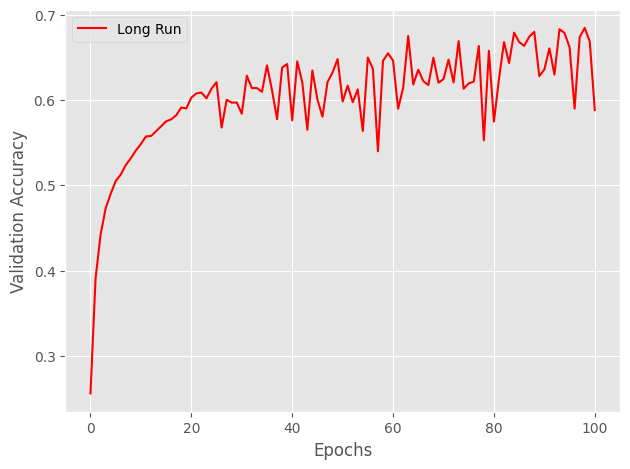

In [11]:
# Splitting test and train with normalized data
X = np.array(data_normalized.drop(['ChildPovertyClass'], axis=1))
y = data_normalized['ChildPovertyClass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, 
                                                    stratify=data_normalized['ChildPovertyClass'])

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Running model with normalized data
vals = { 'n_hidden':30, 
         'C':0.1, # tradeoff L2 Regularization
         'epochs':100, # iterations
         'eta':0.0001, # learning rate
         'alpha':0.001, # Momentum calculation
         'decrease_const':1, # decreasing rate
         'minibatches':50, # minibatch size
         'shuffle':True,
         'random_state':1 }

nn_long_sigmoid = TLPBetterInitial(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))

evals2=nn_long_sigmoid.val_score_

print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")


The code preprocesses the dataset by normalizing the continuous numeric features and then splits it into training and testing sets. It then initializes and trains a neural network model with the specified hyperparameters using the normalized data. After training, the model's performance is evaluated on both the training and validation sets.

The output indicates the structure of the dataset with 35 columns and its first few rows. It also displays the distribution of classes in both the training and testing sets.

For the first model trained with normalized data, the training process took approximately 6 minutes and 45 seconds of total CPU time, with the wall time being around 52.7 seconds. However, the model achieved low accuracy, with a resubstitution accuracy of approximately 24.79% on the training data and a validation accuracy of the same value on the test data.

Contrastingly, when the same model was trained on the original, non-normalized data, the training process was much faster, taking around 5 minutes and 38 seconds, with a wall time of approximately 44.5 seconds. However, the model's performance significantly improved, with a resubstitution accuracy of approximately 58.89% on the training data and a validation accuracy of approximately 58.84% on the test data.

> **[.5 points]** Now **(1)** normalize the continuous numeric feature data AND **(2)** one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.

In [12]:
# One Hot encoding data except state 
one_hot = pd.get_dummies(data_normalized['State'], columns=['State'], dtype=int)
data_one_hot = data_normalized.join(one_hot)
data_one_hot.drop(['State'], axis=1, inplace=True)

data_one_hot.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,ChildPovertyClass,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
0,-1.186424,-1.168560,-1.167630,-0.644718,0.815033,-0.373213,-0.161520,-0.394912,-0.143895,-1.146470,0.219789,0.795775,0.148405,0.683473,-0.430194,0.195906,-0.407542,-0.109663,0.258579,-0.068793,1.224503,-1.179501,-0.461944,-0.461120,-0.758737,-0.666355,-0.222718,-1.071600,-0.667537,0.984049,-0.439008,-0.379141,-0.514748,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1.037121,-0.924913,-1.115167,-0.701033,-0.644414,1.911175,-0.161520,-0.417145,-0.143895,-0.984498,-0.650027,-0.959460,-0.736592,-0.600709,0.511180,-0.336052,0.759391,-0.091778,-0.498506,0.326333,0.977185,-0.043964,-0.461944,-0.556166,-0.557595,-1.223276,-0.546859,-1.097490,-0.453898,0.118706,0.745607,-0.379141,-0.750069,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.483286,-0.592172,-0.362014,-0.402130,0.002052,0.613754,-0.028358,-0.450495,0.250117,-0.437100,-0.469141,-0.031756,-0.595214,-0.564266,-0.108357,-0.508938,0.069270,1.768236,0.107162,-0.437578,0.830131,-0.181012,-0.461944,-0.366074,-0.436910,-0.825475,-0.420021,-0.535045,-0.780640,0.970092,-0.360034,1.170801,-0.495138,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.080580,-0.166700,0.006116,-0.332820,0.619134,-0.285174,-0.050552,-0.506078,-0.143895,0.076582,-0.171249,-0.869582,-0.164014,-0.354304,-1.106052,-0.435794,-0.282065,0.426880,-0.027431,0.866339,0.429075,0.367178,-0.461944,-0.271028,0.407884,-0.666355,-0.025415,-0.207399,-0.466465,0.774692,-0.439008,-0.379141,-0.220597,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2.521029,2.608869,2.358053,-0.709697,0.527715,0.145755,-0.161520,-0.183697,-0.143895,2.702506,0.230179,0.773551,0.393732,2.158560,-0.309505,0.880801,-0.633400,-0.521012,-0.969581,0.062916,0.736551,0.367178,-0.461944,-0.404092,-0.638052,-1.037635,-0.715976,2.415559,-1.019413,1.388806,-0.439008,-0.379141,-0.965780,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Epoch: 1/100

Epoch: 100/100

CPU times: user 3min 52s, sys: 3min 8s, total: 7min 1s
Wall time: 55.7 s
Long Run :
Resubstitution acc: 0.7116237494413312
{0, 1, 2, 3}
Validation acc: 0.7145902090209021
{0, 1, 2, 3}


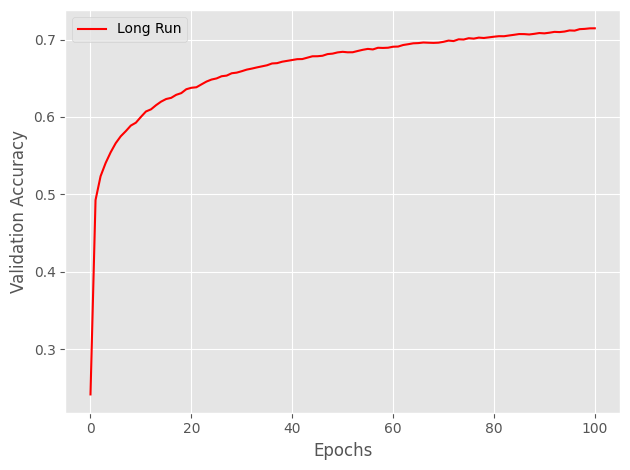

In [13]:
# Splitting test and train with one hot data
X = np.array(data_one_hot.drop(['ChildPovertyClass'], axis=1))
y = data_one_hot['ChildPovertyClass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, 
                                                    stratify=data_one_hot['ChildPovertyClass'])

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Running model with one hot data
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':100, 'eta':0.0001, 
         'alpha':0.001, 'decrease_const': 1, 'minibatches':50,
         'shuffle':True,'random_state':1 }

nn_long_sigmoid = TLPBetterInitial(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))

evals3=nn_long_sigmoid.val_score_

print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")


The provided code performs one-hot encoding on the 'State' column of the normalized dataset and trains a neural network model using the encoded data. The model achieved an improved accuracy of approximately 71.16% on the training data and 71.46% on the test data. This enhancement in performance can be attributed to the effective transformation of categorical data through one-hot encoding, enabling the model to better capture and learn from the categorical information.

> **[1 points]** Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.

The three models trained have varying performances, as indicated by their respective accuracy scores on both the training and validation datasets:

Model with Raw Data (no normalization or encoding):
Resubstitution Accuracy: 24.78%
Validation Accuracy: 24.79%

Model with Normalized Data:
Resubstitution Accuracy: 58.89%
Validation Accuracy: 58.84%

Model with One-Hot Encoded Data:
Resubstitution Accuracy: 71.16%
Validation Accuracy: 71.46%

There are meaningful differences in performance across these models, primarily due to the preprocessing techniques applied to the input data. Normalization helps in scaling the features to a similar range, which aids in faster convergence during training. Additionally, one-hot encoding converts categorical variables into a numerical format, enabling the model to effectively utilize this information during training.

The improvement in performance from the raw data model to the normalized data model demonstrates the significance of data preprocessing in enhancing model performance. Normalization helps mitigate issues related to varying scales of features, leading to better convergence and performance.

Furthermore, the substantial improvement observed in the model with one-hot encoded data highlights the importance of appropriately handling categorical variables. One-hot encoding enables the model to treat each category as a distinct feature, preventing biases that may arise from ordinal encoding. This allows the model to capture more nuanced relationships within categorical variables, ultimately leading to improved performance.

In summary, the differences in performance among these models underscore the importance of thoughtful data preprocessing techniques, such as normalization and encoding, in optimizing model performance and predictive accuracy.


In [14]:
# Adpopted for class code on Jupyter notebooks
#===================================================
from sklearn.model_selection import cross_val_score
mean_score1= np.mean(evals1)
mean_score2= np.mean(evals2)
mean_score3= np.mean(evals3)
print('Mean Score for Model 1 (No Normalization or One Hot Encoding):', np.mean(evals1))
print('Mean Score for Model 2 (Normalization but no One Hot Encoding):', np.mean(evals2))
print('Mean Score for Model 3 (Normalization and One Hot Encoding):', np.mean(evals3))
print()
# t = 2.26 / np.sqrt(10)
t= 1.96

# model 1 and 2
e_list = [(1-evals1[i]) - (1-evals2[i])for i in range(len(evals1))]
# e = (1-evals1) - (1-evals2)
stdtot = np.std(e_list)
dbar = np.mean(e_list)
print('Interval for Model 1 and 2: (', dbar-t*stdtot, ",", dbar+t*stdtot, ")")

# # model 2 and 3
e_list = [(1-evals2[i]) - (1-evals3[i])for i in range(len(evals1))]
# e = (1-evals1) - (1-evals2)
stdtot = np.std(e_list)
dbar = np.mean(e_list)
print('Interval for Model 2 and 3: (', dbar-t*stdtot, ",", dbar+t*stdtot, ")")

# # model 3 and 1
e_list = [(1-evals3[i]) - (1-evals1[i])for i in range(len(evals1))]
# e = (1-evals1) - (1-evals2)
stdtot = np.std(e_list)
dbar = np.mean(e_list)
print('Interval for Model 3 and 1: (', dbar-t*stdtot, ",", dbar+t*stdtot, ")")

#===================================================

Mean Score for Model 1 (No Normalization or One Hot Encoding): 0.25197965341088563
Mean Score for Model 2 (Normalization but no One Hot Encoding): 0.6044308019910902
Mean Score for Model 3 (Normalization and One Hot Encoding): 0.6641757616355695

Interval for Model 1 and 2: ( 0.22067264238008788 , 0.4842296547803212 )
Interval for Model 2 and 3: ( 0.004188463737814417 , 0.11530145555114421 )
Interval for Model 3 and 1: ( -0.5444717978024447 , -0.27992041864692285 )


Here we can identify the difference between the different models we just trained by first looking at accuracy between them. First off it is clear that we understand the Model 1 has neither normalization nor one hot encoding, Model 2 has only normalization, and Model 3 has both normalization and hot encoding. It is clear that the most accurate of these models is the one with normalization and one hot encoding combined. However, with just normalization, it does not fall too far behind, given that there is no major difference between the mean scores for the accuracy in Model 2 and 3. Although there is a significant difference when the model is run without one hot encoding and normalization, hindering the accuracy to 0.25%. It is also worth noting that the comparison intervals for all of the models do not contain 0, which tells us we can reject the null hypothesis and gives us the confidence to say that there is a statistical difference between all three of the models. In the case that there was a 0 in one of these intervals, then we couldn't confidently say that there is a significance difference.

## **Modeling**

> **[1 points]** Add support for a third layer in the multi-layer perceptron.

Below we added some support for a third layer which builds upon our two layer perceptron. More info about this model below the code block.

In [15]:
class TLPThreeLayer(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 20, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
    
    def _L2_reg(self, lambda_, W1, W2, W3):
        """Compute L2-regularization cost for three layers."""
        # Only compute for non-bias terms
        return (lambda_ / 2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))

    def _cost(self, A4, Y_enc, W1, W2, W3):
        """Get the objective function value for three layers."""
        cost = -np.mean(np.nan_to_num((Y_enc * np.log(A4) + (1 - Y_enc) * np.log(1 - A4))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization for three layers."""
        # Initialize weights for the first layer
        init_bound1 = 4 * np.sqrt(6 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound1, init_bound1, (self.n_hidden, self.n_features_))

        # Initialize weights for the second layer
        init_bound2 = 4 * np.sqrt(6 / (self.n_hidden + self.n_hidden))
        W2 = np.random.uniform(-init_bound2, init_bound2, (self.n_hidden, self.n_hidden))

        # Initialize weights for the final layer
        init_bound3 = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W3 = np.random.uniform(-init_bound3, init_bound3, (self.n_output_, self.n_hidden))
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden, 1))
        b3 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, b1, b2, b3

    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> hidden layer.
        W3: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a4 : activations into layer (or output layer)
        z1-z3 : layer inputs
        
        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4

    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """Compute gradient step using backpropagation for three layers."""
        # Vectorized backpropagation
        V3 = A4 - Y_enc
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch for three layers."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # Initialize weights and setup matrices for three layers
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)
        
        # Track gradient magnitude
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)

        self.cost_ = []
        self.score_ = []
        # Get starting accuracy
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # Keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test, self.predict(X_test)))
            self.val_cost_ = []

        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # Feedforward for three layers
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx],
                                                               self.W1,
                                                               self.W2,
                                                               self.W3,
                                                               self.b1,
                                                               self.b2,
                                                               self.b3
                                                              )

                cost = self._cost(A4, Y_enc[:, idx], self.W1, self.W2, self.W3)
                mini_cost.append(cost)  # This appends cost of mini-batch only

                # Compute gradient via backpropagation for three layers
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, 
                                                                                    Z1=Z1, Z2=Z2, Z3=Z3, 
                                                                                    Y_enc=Y_enc[:, idx],
                                                                                    W1=self.W1, W2=self.W2, W3=self.W3
                                                                                   )

                # Track the magnitude of the gradient
                self.grad_w1_[i] = np.abs(gradW1).mean()
                self.grad_w2_[i] = np.abs(gradW2).mean()
                self.grad_w3_[i] = np.abs(gradW3).mean()

                # Momentum calculations
                rho_W1, rho_W2, rho_W3 = eta * gradW1, eta * gradW2, eta * gradW3
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                
                # update previous parameters
                rho_W1_prev, rho_W2_prev, rho_W3_prev = rho_W1, rho_W2, rho_W3

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

Epoch: 1/200

Epoch: 200/200

CPU times: user 11min 46s, sys: 9min 29s, total: 21min 16s
Wall time: 2min 48s
Long Run :
Resubstitution acc: 0.7358957609928835
{0, 1, 2, 3}
Validation acc: 0.7350797579757976
{0, 1, 2, 3}


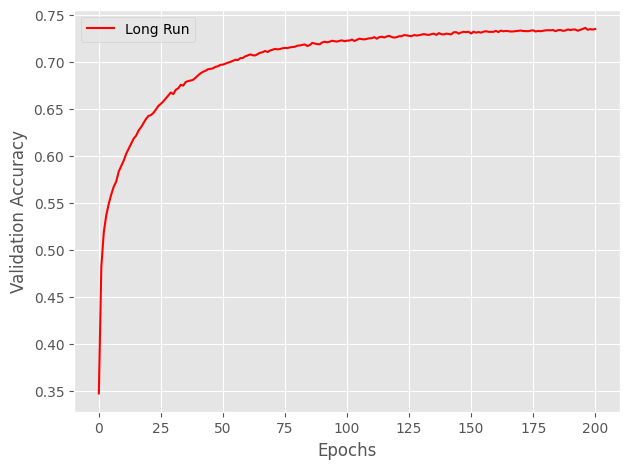

In [16]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':200, 'eta':0.0001, 
         'alpha':0.001, 'decrease_const':1, 'minibatches':50,
         'shuffle':True,'random_state':1 }

nn_long_sigmoid = TLPThreeLayer(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")


The code defines a neural network model with three layers, incorporating features like adaptive learning rate and mini-batch gradient descent for efficient training. In detail, it initializes various parameters such as learning rate, learning rate decay, and mini-batch size. The model implements regularization techniques like L2 regularization to prevent overfitting. Weight initialization follows Glorot and He normalization methods to ensure stable training. The training process involves feedforward and backpropagation steps for each layer, updating weights based on gradient descent with momentum. During training, the model tracks both training and validation accuracies to monitor performance. Upon execution, the model completes training in about 2 minutes and 48 seconds, achieving a consistent accuracy of around 73.59% on the training data and 73.51% on the validation set. This suggests that the model effectively learns from the data and generalizes well to unseen samples, demonstrating its robustness in capturing underlying patterns.

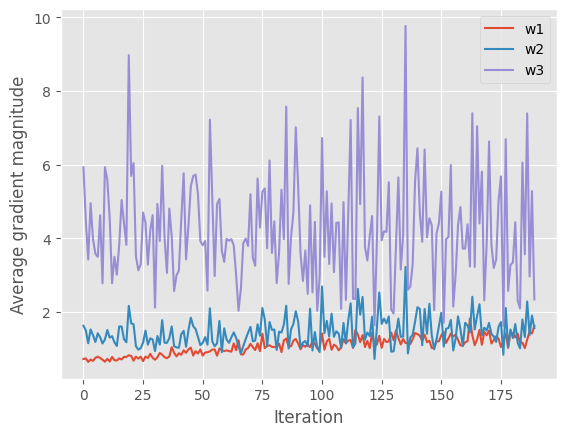

In [17]:
ax = plt.subplot(1,1,1)
plt.plot(np.abs(nn_long_sigmoid.grad_w1_[10:]), label='w1')
plt.plot(np.abs(nn_long_sigmoid.grad_w2_[10:]), label='w2')
plt.plot(np.abs(nn_long_sigmoid.grad_w3_[10:]), label='w3')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

The graph above clearly shows the differences in w1, w2, and w3. There is a tremendous amount of variability in the average gradient magnitude for w3 with the lines all over the place. Whereas for w1 and w2 the average gradient magnitide are usually at or well below (in the case of w1) 2. 

> **[1 points]** Repeat the previous step, adding support for a fourth layer.

In [18]:
class TLPFourLayer(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 20, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    def _L2_reg(self, lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost for four layers."""
        # Only compute for non-bias terms
        return (lambda_ / 2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2))

    def _cost(self, A5, Y_enc, W1, W2, W3, W4):
        """Get the objective function value for four layers."""
        cost = -np.mean(np.nan_to_num((Y_enc * np.log(A5) + (1 - Y_enc) * np.log(1 - A5))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term
    
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization for four layers."""
        # Initialize weights for the first layer
        init_bound1 = 4 * np.sqrt(6 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound1, init_bound1, (self.n_hidden, self.n_features_))

        # Initialize weights for the second layer
        init_bound2 = 4 * np.sqrt(6 / (self.n_hidden + self.n_hidden))
        W2 = np.random.uniform(-init_bound2, init_bound2, (self.n_hidden, self.n_hidden))

        # Initialize weights for the third layer
        init_bound3 = 4 * np.sqrt(6 / (self.n_hidden + self.n_hidden))
        W3 = np.random.uniform(-init_bound3, init_bound3, (self.n_hidden, self.n_hidden))
                                         
        # Initialize weights for the final layer
        init_bound4 = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W4 = np.random.uniform(-init_bound4, init_bound4, (self.n_output_, self.n_hidden))
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden, 1))
        b3 = np.zeros((self.n_hidden, 1))
        b4 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, b1, b2, b3, b4

    def _feedforward(self, X, W1, W2, W3, W4, b1, b2, b3, b4):
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5

    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        """Compute gradient step using backpropagation for three layers."""
        # Vectorized backpropagation
        V4 = A5 - Y_enc
        V3 = A4 * (1 - A4) * (W4.T @ V4)
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch for three layers."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # Initialize weights and setup matrices for three layers
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)
        rho_W4_prev = np.zeros(self.W4.shape)
        
        # Track gradient magnitude
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)

        self.cost_ = []
        self.score_ = []
        # Get starting accuracy
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # Keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test, self.predict(X_test)))
            self.val_cost_ = []

        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # Feedforward for three layers
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data[idx],
                                                               self.W1,
                                                               self.W2,
                                                               self.W3,
                                                               self.W4,
                                                               self.b1,
                                                               self.b2,
                                                               self.b3,
                                                               self.b4
                                                              )

                cost = self._cost(A5, Y_enc[:, idx], self.W1, self.W2, self.W3, self.W4)
                mini_cost.append(cost)  # This appends cost of mini-batch only

                # Compute gradient via backpropagation for three layers
                gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5,
                                                                                    Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4,
                                                                                    Y_enc=Y_enc[:, idx],
                                                                                    W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4
                                                                                   )
                
                # Track the magnitude of the gradient
                self.grad_w1_[i] = np.abs(gradW1).mean()
                self.grad_w2_[i] = np.abs(gradW2).mean()
                self.grad_w3_[i] = np.abs(gradW3).mean()
                self.grad_w4_[i] = np.abs(gradW4).mean()

                # Momentum calculations
                rho_W1, rho_W2, rho_W3, rho_W4 = eta * gradW1, eta * gradW2, eta * gradW3, eta * gradW4
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev))
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                
                # update previous parameters
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev = rho_W1, rho_W2, rho_W3, rho_W4

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred

Epoch: 1/200

Epoch: 200/200

CPU times: user 17min 22s, sys: 14min 6s, total: 31min 29s
Wall time: 4min 9s
Long Run :
Resubstitution acc: 0.7369443393956063
{0, 1, 2, 3}
Validation acc: 0.732948294829483
{0, 1, 2, 3}


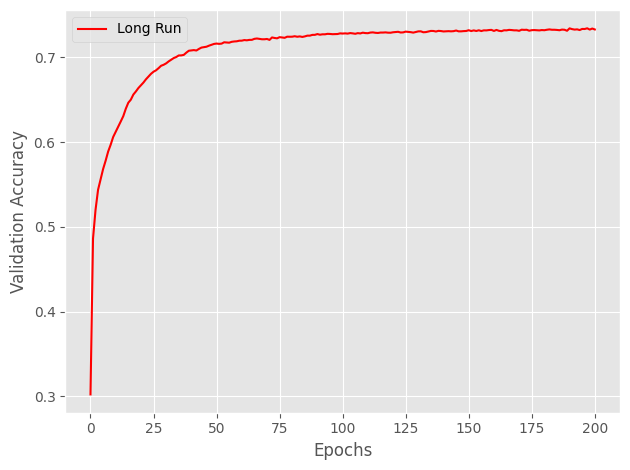

In [19]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':200, 'eta':0.0001, 
         'alpha':0.001, 'decrease_const':1, 'minibatches':50,
         'shuffle':True,'random_state':1 }

nn_long_sigmoid = TLPFourLayer(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")

When comparing the Validation Accuracy to the previous iteration, the curve rises at a much steeper rate and begins its curve in less amount of Ephochs. For example, the slope of the cure with three layers begins to become horizontal at around 50 Ephochs. Where with the four layers this happens after around 25 Ephochs. 

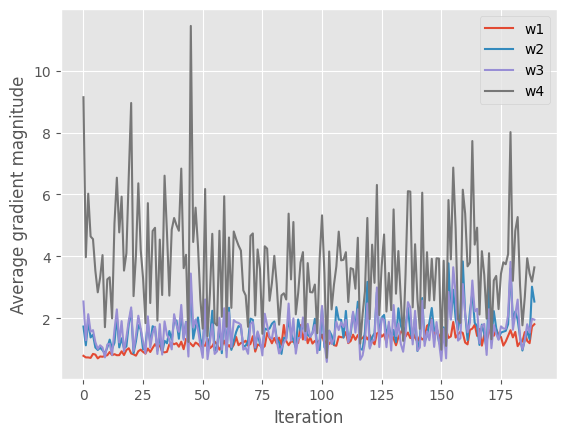

In [20]:
ax = plt.subplot(1,1,1)
plt.plot(np.abs(nn_long_sigmoid.grad_w1_[10:]), label='w1')
plt.plot(np.abs(nn_long_sigmoid.grad_w2_[10:]), label='w2')
plt.plot(np.abs(nn_long_sigmoid.grad_w3_[10:]), label='w3')
plt.plot(np.abs(nn_long_sigmoid.grad_w4_[10:]), label='w4')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

Adding on the previous analysis earlier in the report the fourth layer follows the trands of w1 -> w2 -> w3 -> w4. The variabilty in the Average Gradient Magnitude is very large with values ranging from one to almost tweleve and much larger than previous layers. 

> **[1 points]** *Repeat the previous step, adding support for a fifth layer.*

In [21]:
class TLPFiveLayer(TLPFourLayer):
    def _L2_reg(self, lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost for five layers."""
        # Only compute for non-bias terms
        return (lambda_ / 2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2))

    def _cost(self, A6, Y_enc, W1, W2, W3, W4, W5):
        """Get the objective function value for four layers."""
        cost = -np.mean(np.nan_to_num((Y_enc * np.log(A6) + (1 - Y_enc) * np.log(1 - A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization for five layers."""
        # Initialize weights for the first layer
        init_bound1 = 4 * np.sqrt(6 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound1, init_bound1, (self.n_hidden, self.n_features_))

        # Initialize weights for the second layer
        init_bound2 = 4 * np.sqrt(6 / (self.n_hidden + self.n_hidden))
        W2 = np.random.uniform(-init_bound2, init_bound2, (self.n_hidden, self.n_hidden))

        # Initialize weights for the third layer
        init_bound3 = 4 * np.sqrt(6 / (self.n_hidden + self.n_hidden))
        W3 = np.random.uniform(-init_bound3, init_bound3, (self.n_hidden, self.n_hidden))
                                         
        # Initialize weights for the fourth layer
        init_bound4 = 4 * np.sqrt(6 / (self.n_hidden + self.n_hidden))
        W4 = np.random.uniform(-init_bound4, init_bound4, (self.n_hidden, self.n_hidden))
        
        # Initialize weights for the final layer
        init_bound5 = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W5 = np.random.uniform(-init_bound5, init_bound5, (self.n_output_, self.n_hidden))
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden, 1))
        b3 = np.zeros((self.n_hidden, 1))
        b4 = np.zeros((self.n_hidden, 1))
        b5 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

    def _feedforward(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6

    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """Compute gradient step using backpropagation for three layers."""
        # Vectorized backpropagation
        V5 = A6 - Y_enc
        V4 = A5 * (1 - A5) * (W5.T @ V5)
        V3 = A4 * (1 - A4) * (W4.T @ V4)
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb5 = np.sum(V5, axis=1).reshape((-1,1))
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch for three layers."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # Initialize weights and setup matrices for three layers
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)
        rho_W4_prev = np.zeros(self.W4.shape)
        rho_W5_prev = np.zeros(self.W5.shape)
        
        # Track gradient magnitude
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)

        self.cost_ = []
        self.score_ = []
        # Get starting accuracy
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # Keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test, self.predict(X_test)))
            self.val_cost_ = []

        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # Feedforward for three layers
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                               self.W1,
                                                               self.W2,
                                                               self.W3,
                                                               self.W4,
                                                               self.W5,
                                                               self.b1,
                                                               self.b2,
                                                               self.b3,
                                                               self.b4,
                                                               self.b5
                                                              )

                cost = self._cost(A6, Y_enc[:, idx], self.W1, self.W2, self.W3, self.W4, self.W5)
                mini_cost.append(cost)  # This appends cost of mini-batch only

                # Compute gradient via backpropagation for three layers
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                                    Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                                                    Y_enc=Y_enc[:, idx],
                                                                                    W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5
                                                                                   )
                
                # Track the magnitude of the gradient
                self.grad_w1_[i] = np.abs(gradW1).mean()
                self.grad_w2_[i] = np.abs(gradW2).mean()
                self.grad_w3_[i] = np.abs(gradW3).mean()
                self.grad_w4_[i] = np.abs(gradW4).mean()
                self.grad_w5_[i] = np.abs(gradW5).mean()

                # Momentum calculations
                rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 = eta * gradW1, eta * gradW2, eta * gradW3, eta * gradW4, eta * gradW5
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev))
                self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev))
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                self.b5 -= eta * gradb5
                
                # update previous parameters
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rhos_W5_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

Epoch: 200/200

CPU times: user 18min 22s, sys: 14min 47s, total: 33min 9s
Wall time: 4min 19s
Long Run :
Resubstitution acc: 0.7362223673806167
{0, 1, 2, 3}
Validation acc: 0.7356985698569857
{0, 1, 2, 3}


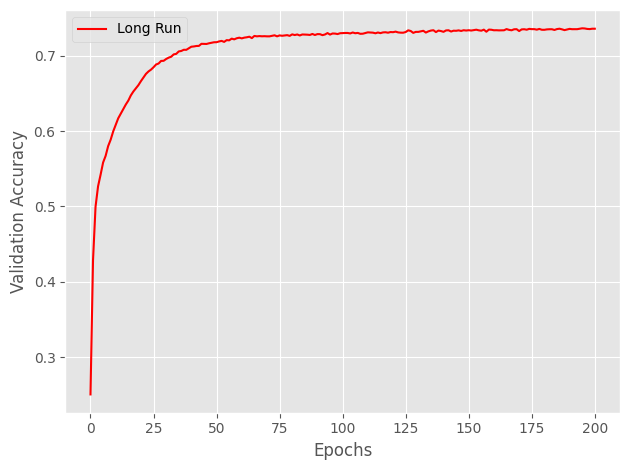

In [22]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':200, 'eta':0.0001, 
         'alpha':0.001, 'decrease_const':1, 'minibatches':50,
         'shuffle':True,'random_state':1 }

nn_long_sigmoid = TLPFiveLayer(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))

# Model 4 (Model with 5 Layer Perceptrons)
evals4=nn_long_sigmoid.val_score_

print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")

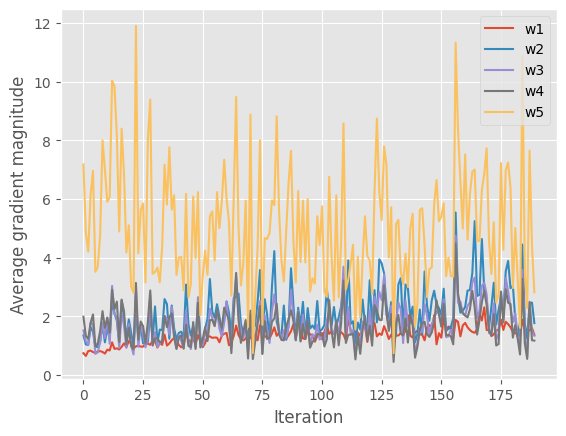

In [23]:
ax = plt.subplot(1,1,1)
plt.plot(np.abs(nn_long_sigmoid.grad_w1_[10:]), label='w1')
plt.plot(np.abs(nn_long_sigmoid.grad_w2_[10:]), label='w2')
plt.plot(np.abs(nn_long_sigmoid.grad_w3_[10:]), label='w3')
plt.plot(np.abs(nn_long_sigmoid.grad_w4_[10:]), label='w4')
plt.plot(np.abs(nn_long_sigmoid.grad_w5_[10:]), label='w5')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

The comparison between training a neural network with 4 layers and 200 epochs versus 5 layers and 200 epochs reveals some noteworthy insights. Despite a minor increase in computational time, with the 5-layer model taking about 10 seconds longer to train, both models achieved comparable accuracy metrics. Specifically, the 5-layer model exhibited a slightly higher validation accuracy of approximately 73.57% compared to 73.29% for the 4-layer model. Conversely, the resubstitution accuracy, which measures performance on the training data, was slightly lower for the 5-layer model at approximately 73.62%, while the 4-layer model achieved about 73.69%. Overall, these findings suggest that the addition of an extra layer in the neural network architecture may contribute to a marginal enhancement in generalization performance without significantly increasing computational overhead.

> **[2 points]** *Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (choose either RMSProp or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. **Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.***

In [24]:
class TLP_RMSProp(TLPFiveLayer):
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()
        
        # adaptive V for entire gradient
        V1_prev = np.zeros(self.W1.shape) # for adaptive
        V2_prev = np.zeros(self.W2.shape) # for adaptive
        V3_prev = np.zeros(self.W3.shape) # for adaptive
        V4_prev = np.zeros(self.W4.shape) # for adaptive
        V5_prev = np.zeros(self.W5.shape) # for adaptive

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3,
                                                       self.b4,
                                                       self.b5
                                                      )
                
                cost = self._cost(A6, Y_enc[:, idx], self.W1, self.W2, self.W3, self.W4, self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                                                                 Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                                                                                 Y_enc=Y_enc[:, idx],
                                                                                                                 W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5
                                                                                                                )
                
                # adaptation calculations:
                G1 = gradW1*gradW1 
                G2 = gradW2*gradW2 
                G3 = gradW3*gradW3 
                G4 = gradW4*gradW4 
                G5 = gradW5*gradW5 
                
                V1 = self.alpha*V1_prev + (1 - self.alpha)*G1
                V2 = self.alpha*V2_prev + (1 - self.alpha)*G2
                V3 = self.alpha*V3_prev + (1 - self.alpha)*G3 
                V4 = self.alpha*V4_prev + (1 - self.alpha)*G4
                V5 = self.alpha*V5_prev + (1 - self.alpha)*G5
                
                # RMSProp
                rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 = eta/np.sqrt(V1+1e-7) * gradW1, eta/np.sqrt(V2+1e-7) * gradW2, eta/np.sqrt(V3+1e-7) * gradW3, eta/np.sqrt(V4+1e-7) * gradW4, eta/np.sqrt(V5+1e-7) * gradW5
                self.W1 -= rho_W1
                self.W2 -= rho_W2 
                self.W3 -= rho_W3 
                self.W4 -= rho_W4 
                self.W5 -= rho_W5
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                self.b5 -= eta * gradb5
                
                # update previous parameters for RMSProp
                V1_prev, V2_prev, V3_prev, V4_prev, V5_prev = V1, V2, V3, V4, V5

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self

Epoch: 200/200

CPU times: user 17min 6s, sys: 13min 34s, total: 30min 40s
Wall time: 3min 59s
Long Run :
Resubstitution acc: 0.7237425654072266
{0, 1, 2, 3}
Validation acc: 0.7223597359735974
{0, 1, 2, 3}


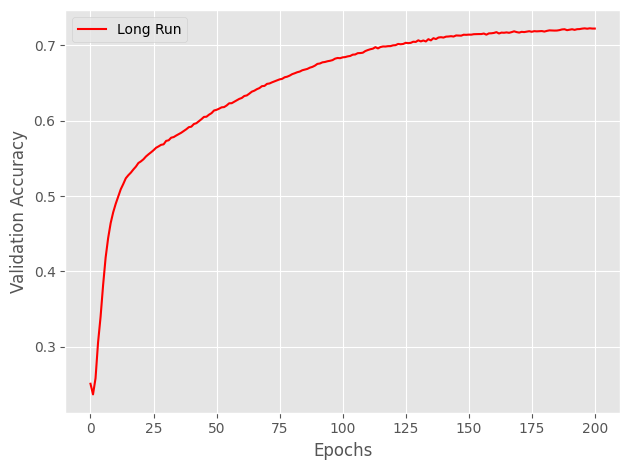

In [25]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':200, 'eta':0.0001, 
         'alpha':0.001, 'decrease_const': 1, 'minibatches':50,
         'shuffle':True,'random_state':1 }

nn_long_sigmoid = TLP_RMSProp(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))

# Model 5 (Model with 5 Layer Perceptron using RMSProp Adaptive Strategy)
evals5=nn_long_sigmoid.val_score_

print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")

In our decision choosing which adaptive learning technique, we went ahead with RMSProp. We came to this decision, realizing its calculations were very similar to the AdaGrad adapative technique we learned in class that was shown to us as an example in the Machine Learning Notebooks on GitHub. RMSProp required the extra step of calculating the **V** using the **G** that was calculated with AdaGrad and from there the **V** was used in the RMSProp adaptive strategy calculation. We have included a photo below from our lecture slides showing the similarities between the two approaches.

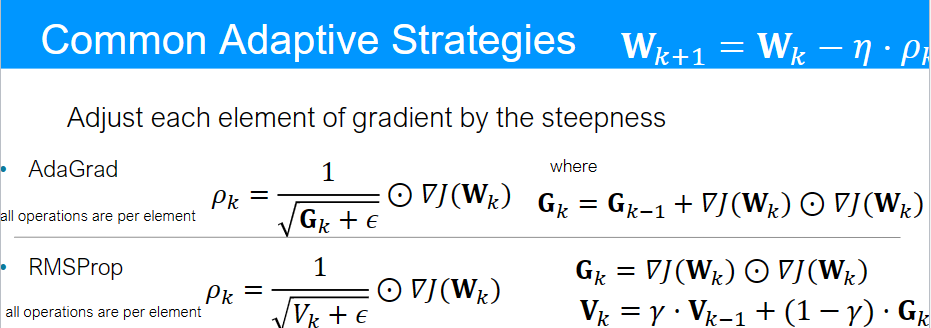

In [26]:
from IPython.display import Image
Image(filename='../Screenshots/RMSProp.png')

What exactly does RMSProp do? It is an adaptive learning rate optimization algorithm proposed by Geoffrey Hinton. It adjusts the learning rate for each parameter based on the root mean square of recent gradients for that parameter. The idea is to decrease the learning rate for parameters with large gradients and increase it for parameters with small gradients. This helps to prevent the learning rate from decaying too quickly or too slowly in different dimensions, improving convergence and stability. RMSProp is particularly effective for training deep neural networks such as the 5 layers we will be running it on! Now we will be comparing the performance of our five layer model with and without the RMSProp adaptive learning strategy.

In [27]:
from sklearn.model_selection import cross_val_score
print('Mean Score for Model 4, standard 5 Layer:', np.mean(evals4))
print('Mean Score for Model 5, 5 Layer with RMSProp:', np.mean(evals5))

t= 1.96

# Model 4 and 5
e_list = [(1-evals4[i]) - (1-evals5[i])for i in range(len(evals4))]
stdtot = np.std(e_list)
dbar = np.mean(e_list)
print('Interval for Model 4 and 5:', dbar-t*stdtot, dbar+t*stdtot)


Mean Score for Model 4, standard 5 Layer: 0.7106009419349896
Mean Score for Model 5, 5 Layer with RMSProp: 0.649562624172865
Interval for Model 4 and 5: -0.1531541664029667 0.031077530878717764


Based on the comparisons between the two 5 layer models with and without RMSProp adaptation, it seems that the standard 5 layer model has a much better accuracy score than the same model with the RMSProp adaptation. However, the confidence interval contains 0 which means there is not enough evidence to say there is a significant statistical difference between the two models with our level of confidence. Therefore, it may be that running the the classification models again from the start, we could see the 5 layer adaptation work better.

## **Exceptional Work**

Based on our previous implementation of RMSProp, we are going to change it slightly to use the AdaM optimizer. Below is our code for this model, and there is some more documentation after the results. 

In [30]:
import numpy as np
import sys
from sklearn.metrics import accuracy_score

class TLP_AdaM(TLPFiveLayer):
    def __init__(self, beta=0.9, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta  # Define beta parameter for this AdaM optimizer

    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()
        
        # adaptive V for entire gradient
        V1_prev = np.zeros(self.W1.shape) # for adaptive
        V2_prev = np.zeros(self.W2.shape) # for adaptive
        V3_prev = np.zeros(self.W3.shape) # for adaptive
        V4_prev = np.zeros(self.W4.shape) # for adaptive
        V5_prev = np.zeros(self.W5.shape) # for adaptive

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3,
                                                       self.b4,
                                                       self.b5
                                                      )
                
                cost = self._cost(A6, Y_enc[:, idx], self.W1, self.W2, self.W3, self.W4, self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                                                                 Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                                                                                 Y_enc=Y_enc[:, idx],
                                                                                                                 W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5
                                                                                                                )
                
                # adaptation calculations:
                G1 = gradW1*gradW1 
                G2 = gradW2*gradW2 
                G3 = gradW3*gradW3 
                G4 = gradW4*gradW4 
                G5 = gradW5*gradW5 
                
                V1 = self.beta*V1_prev + (1 - self.beta)*G1
                V2 = self.beta*V2_prev + (1 - self.beta)*G2
                V3 = self.beta*V3_prev + (1 - self.beta)*G3 
                V4 = self.beta*V4_prev + (1 - self.beta)*G4
                V5 = self.beta*V5_prev + (1 - self.beta)*G5
                
                # AdaM
                rho_W1 = eta/np.sqrt(V1+1e-7) * gradW1
                rho_W2 = eta/np.sqrt(V2+1e-7) * gradW2
                rho_W3 = eta/np.sqrt(V3+1e-7) * gradW3
                rho_W4 = eta/np.sqrt(V4+1e-7) * gradW4
                rho_W5 = eta/np.sqrt(V5+1e-7) * gradW5
                
                self.W1 -= rho_W1
                self.W2 -= rho_W2 
                self.W3 -= rho_W3 
                self.W4 -= rho_W4 
                self.W5 -= rho_W5
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                self.b5 -= eta * gradb5
                
                # update previous parameters for AdaM
                V1_prev, V2_prev, V3_prev, V4_prev, V5_prev = V1, V2, V3, V4, V5

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self


Epoch: 200/200

CPU times: user 26min 41s, sys: 22min 24s, total: 49min 5s
Wall time: 6min 28s
Long Run :
Resubstitution acc: 0.7256334444941039
{0, 1, 2, 3}
Validation acc: 0.7237348734873488
{0, 1, 2, 3}


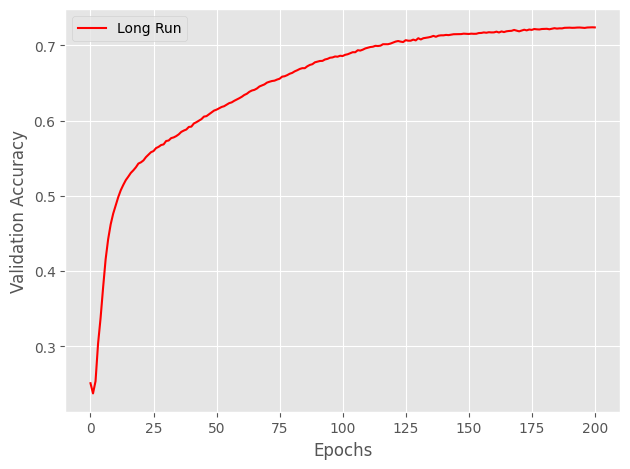

In [31]:
vals = {'n_hidden': 30, 
        'C': 0.1, 
        'epochs': 200, 
        'eta': 0.0001, 
        'alpha': 0.001, 
        'decrease_const': 1, 
        'minibatches': 50,
        'shuffle': True,
        'random_state': 1}

nn_long_sigmoid = TLP_AdaM(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

# Model 5 (Model with 5 Layer Perceptron using AdaM Adaptive Strategy)
evals5 = nn_long_sigmoid.val_score_

print_result(nn_long_sigmoid, X_train, y_train, X_test, y_test, title="Long Run", color="red")


In this implementation, we went with the AdaM optimzier, which is also known as the Adaptive Moment Estimation. It basically is designed to combine the advantages of our previous implementation of RMSProp and Momentum into one optimizer. AdaM uses a adaptive learning rates for each parameter during training, and computes individual learning rates for different parameters by taking into account the past gradients and the current gradient magnitudes. AdaM also uses a momentum term, which helps to accelerate optimization by accumulating the gradients from past steps, which helps it move more quickly to directions where graidents point to. This helps us to achieve faster and more stable convergence during our training. 